In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
gc = pd.read_pickle('gc_23_2018.pickle')
nq = pd.read_pickle('nq_30_2018.pickle')
nkd = pd.read_pickle('nkd_23_2018.pickle')

In [3]:
comp = pd.DataFrame({'gc': gc['returns'],
                    'nq': nq['returns'],
                    'nkd': nkd['returns']
                    })
comp = comp[2:]
comp

,gc,nq,nkd
date,,,
2018-07-06,0.000000,NaN,0.000000
2018-07-09,0.002786,0.000000,0.014085
2018-07-10,0.005399,0.000000,0.001821
2018-07-11,0.002211,0.000000,0.003864
2018-07-12,-0.000158,0.010806,0.009735
...,...,...,...
2018-12-25,0.000000,0.000000,0.000000
2018-12-26,-0.000820,0.022493,0.005687
2018-12-27,-0.003434,0.002959,-0.005445


In [4]:
comp.corr()

,gc,nq,nkd
gc,1.000000,0.007033,0.074135
nq,0.007033,1.000000,0.256090
nkd,0.074135,0.256090,1.000000


In [5]:
growth = comp+1
growth['comp'] = (.4 * growth['gc']) + (.4 * growth['nq']) + (.2 * growth['nkd'])
#growth['comp'] = growth.mean(axis=1)
i = growth.cumprod()
i

,gc,nq,nkd,comp
date,,,,
2018-07-06,1.000000,NaN,1.000000,NaN
2018-07-09,1.002786,1.000000,1.014085,1.003931
2018-07-10,1.008200,1.000000,1.015932,1.006465
2018-07-11,1.010429,1.000000,1.019857,1.008133
2018-07-12,1.010270,1.010806,1.029785,1.014390
...,...,...,...,...
2018-12-25,1.067431,1.119007,1.096283,1.094694
2018-12-26,1.066555,1.144176,1.102517,1.105429
2018-12-27,1.062893,1.147562,1.096514,1.104015


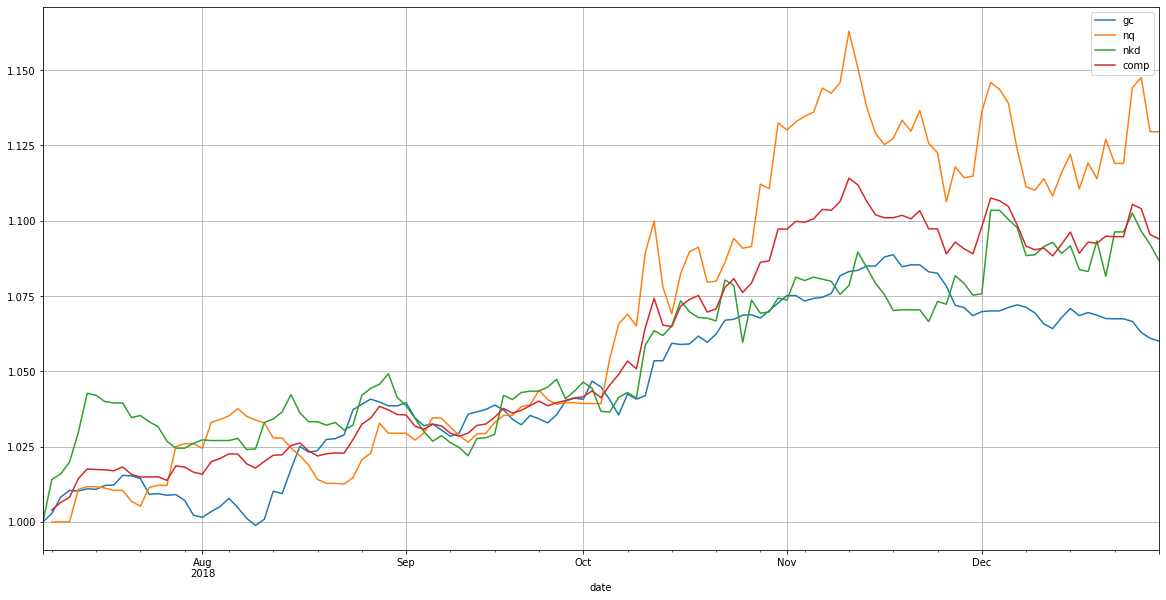

In [6]:
i.plot(figsize=(20,10), grid=True);

In [7]:
pd.DataFrame({n: perf_stats(i[n].pct_change().fillna(0)) for n in i.columns})

,gc,nq,nkd,comp
Annual return,0.122626,0.273415,0.179621,0.185752
Cumulative returns,0.060027,0.129540,0.086816,0.089659
Annual volatility,0.046554,0.112890,0.089923,0.056278
Sharpe ratio,2.508258,2.197892,1.882067,3.056308
Calmar ratio,4.658097,5.614415,6.916946,8.022632
Stability,0.833334,0.851565,0.840185,0.893409
Max drawdown,-0.026325,-0.048699,-0.025968,-0.023154
Omega ratio,1.565921,1.517821,1.431385,1.728364
Sortino ratio,4.667652,3.777789,3.532831,5.389101
Skew,0.849796,0.465839,1.058160,0.406918


In [8]:
m = i.resample('M').last().pct_change()
m

,gc,nq,nkd,comp
date,,,,
2018-07-31,NaN,NaN,NaN,NaN
2018-08-31,0.036222,0.003400,0.014851,0.018815
2018-09-30,0.002453,0.009833,0.001996,0.005362
2018-10-31,0.030359,0.089378,0.029653,0.053813
2018-11-30,-0.003934,-0.015612,0.000860,-0.007495
2018-12-31,-0.007898,0.013221,0.010737,0.004540
